In [1]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns


from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_predict, RandomizedSearchCV

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_percentage_error

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)

In [2]:
df = pd.read_csv('processed_data.csv')
df = pd.get_dummies(df, columns=['model', 'body_type', 'fuel_type', 'transmission', 'colour'])

## Model Selection

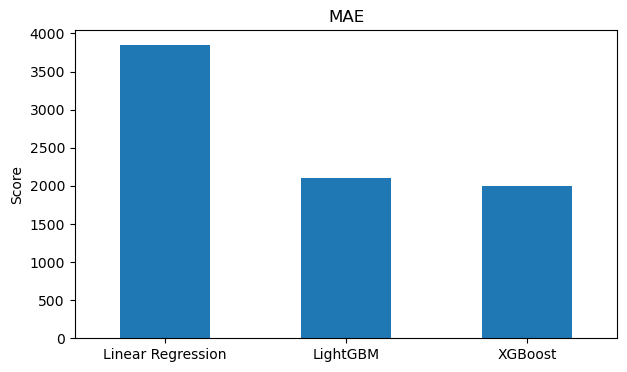

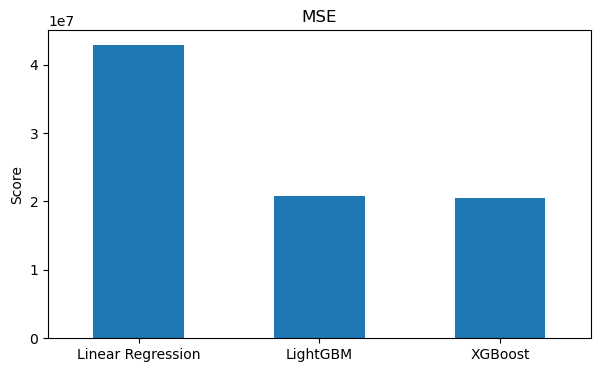

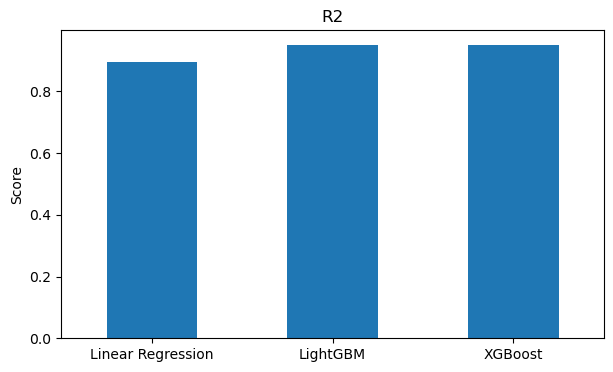

,MAE,MSE,R2
Linear Regression,3848.464437,4.286729e+07,0.895402
LightGBM,2102.478610,2.083678e+07,0.949157
XGBoost,2000.943160,2.050021e+07,0.949978


In [4]:
df = df.fillna(0) ## doing this so the linear regression works, will re-load data later

scaler = StandardScaler()
features = df.drop('price', axis=1)
X = scaler.fit_transform(features)
y = df['price'].values

models = {
    'Linear Regression': LinearRegression(),
    'LightGBM': LGBMRegressor(),
    'XGBoost': XGBRegressor()
}

# K-Fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=123)

# Evaluate metrics
metrics = {
    "MAE": mean_absolute_error,
    "MSE": mean_squared_error,
    "R2": r2_score
}

# Store the results
results = pd.DataFrame([], columns=metrics.keys())

for model_name, model in models.items():
    y_pred = cross_val_predict(model, X, y, cv=kfold)
    
    model_results = {}
    for metric_name, metric_func in metrics.items():
        score = metric_func(y, y_pred)
        model_results[metric_name] = score

    results.loc[model_name] = model_results

for metric in metrics.keys():
    results[metric].plot(kind="bar", figsize=(7, 4), rot=0, title=metric)
    plt.ylabel("Score")
    plt.show()

results

## Hyper-Parameter Optimisation

In [5]:
df = pd.read_csv('processed_data.csv')
df = pd.get_dummies(df, columns=['model', 'body_type', 'fuel_type', 'transmission', 'colour'])

scaler = StandardScaler()
features = df.drop('price', axis=1)
X = scaler.fit_transform(features)
y = df['price'].values

xgb_model = XGBRegressor(objective='reg:squarederror')

param_distributions = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 7, 10],
    'subsample': [0.5, 0.7, 0.9, 1],
    'colsample_bytree': [0.5, 0.7, 0.9, 1],
    'gamma': [0, 0.1, 0.3, 0.5, 1],
    'reg_lambda': [0.01, 0.1, 1],
    'reg_alpha': [0, 0.1, 0.5, 1]
}

random_search = RandomizedSearchCV(
    xgb_model, 
    param_distributions=param_distributions, 
    n_iter=100,
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1, 
    cv=3, 
    verbose=0, 
    random_state=123
)

random_search.fit(X, y)

print("Best hyperparameters:")
print(random_search.best_params_)

Best hyperparameters:
{'subsample': 1, 'reg_lambda': 0.01, 'reg_alpha': 0.5, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 1, 'colsample_bytree': 0.5}


## Train the selected model

/Users/emilygraham/miniforge3/envs/car_prices/lib/python3.8/site-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


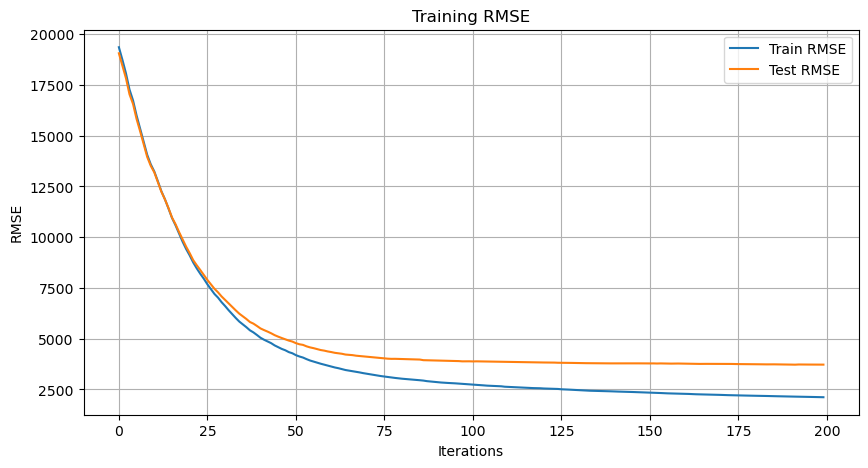

In [6]:
df = pd.read_csv('processed_data.csv')

X_train = df.drop('price', axis=1)
y_train = df['price'].values

test = pd.read_csv('processed_test_data.csv')
X_test = test.drop('price', axis=1)
y_test = test['price'].values

numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

model = XGBRegressor(
    objective='reg:squarederror',
    subsample=0.7,
    reg_lambda=0.1,
    reg_alpha=0.5,
    n_estimators=200,
    max_depth=7,
    learning_rate=0.05,
    gamma=1,
    colsample_bytree=0.5
)

# Preprocess the data using the ColumnTransformer
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Fit the model outside of the pipeline so I can plot rmse for train and test
model.fit(
    X_train_transformed, y_train,
    eval_metric="rmse",
    eval_set=[(X_train_transformed, y_train), (X_test_transformed, y_test)], 
    verbose=False
)

evals_result = model.evals_result()
train_rmse = evals_result['validation_0']['rmse']
test_rmse = evals_result['validation_1']['rmse']

# Plot
plt.figure(figsize=(10, 5))
plt.plot(train_rmse, label='Train RMSE')
plt.plot(test_rmse, label='Test RMSE')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training RMSE')
plt.grid(True)
plt.show()

In [7]:
test_preds = model.predict(X_test_transformed)
train_preds = model.predict(X_train_transformed)

print(mean_absolute_percentage_error(y_train, train_preds))
print(mean_absolute_percentage_error(y_test, test_preds))

0.07078064342166124
0.09771781185464676


## Looking at errors and residuals

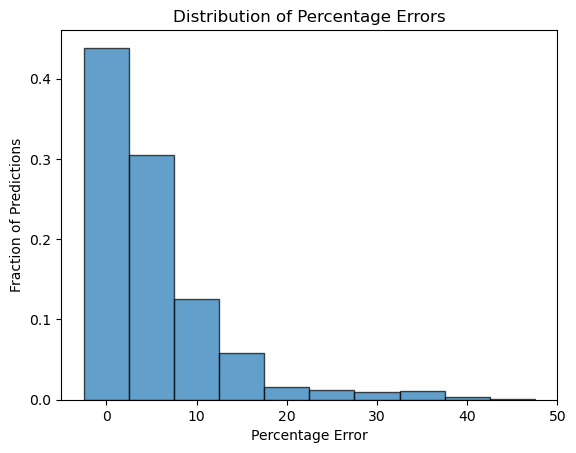

In [8]:
percentage_errors = np.abs((np.array(test_preds) - np.array(y_test)) / np.array(y_test) * 100)

counts, bin_edges = np.histogram(percentage_errors, bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
fractions = counts / len(percentage_errors)

bin_width = bin_edges[1] - bin_edges[0]
plt.bar(bin_edges[:-1], fractions, width=bin_width, edgecolor='black', alpha=0.7)

plt.xlabel('Percentage Error')
plt.ylabel('Fraction of Predictions')
plt.title('Distribution of Percentage Errors')
plt.show()

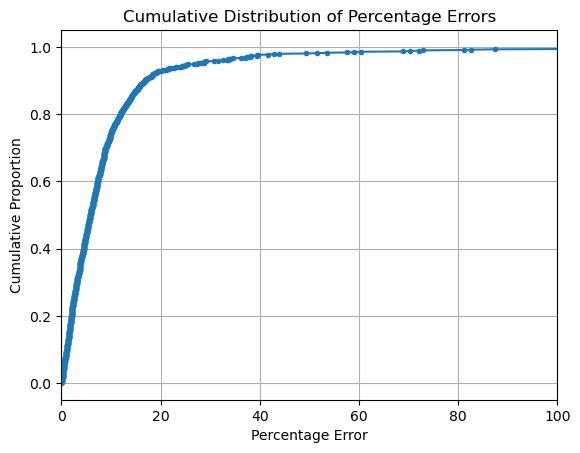

In [9]:
percentage_errors = np.abs((np.array(test_preds) - np.array(y_test)) / np.array(y_test) * 100)

sorted_unique_errors, indices, counts = np.unique(percentage_errors, return_inverse=True, return_counts=True)
cumulative_counts = np.cumsum(counts) / len(percentage_errors)

plt.plot(sorted_unique_errors, cumulative_counts, marker='.', linestyle='-')

plt.xlabel('Percentage Error')
plt.ylabel('Cumulative Proportion')
plt.title('Cumulative Distribution of Percentage Errors')
plt.grid(True)
plt.xlim(0,100)
plt.show()


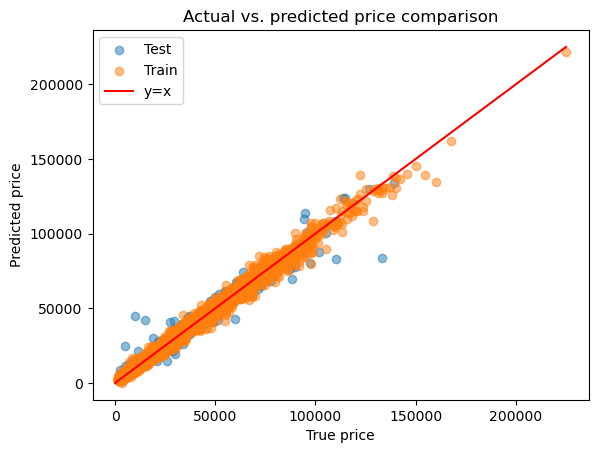

In [13]:
max = 225000

plt.scatter(y_test, test_preds, label='Test', alpha=0.5)
plt.scatter(y_train, train_preds, label='Train', alpha=0.5)
plt.xlabel('True price')
plt.ylabel('Predicted price')
plt.title('Actual vs. predicted price comparison')
plt.plot([0,max],[0,max], color='red',label='y=x')
plt.legend()
plt.show()

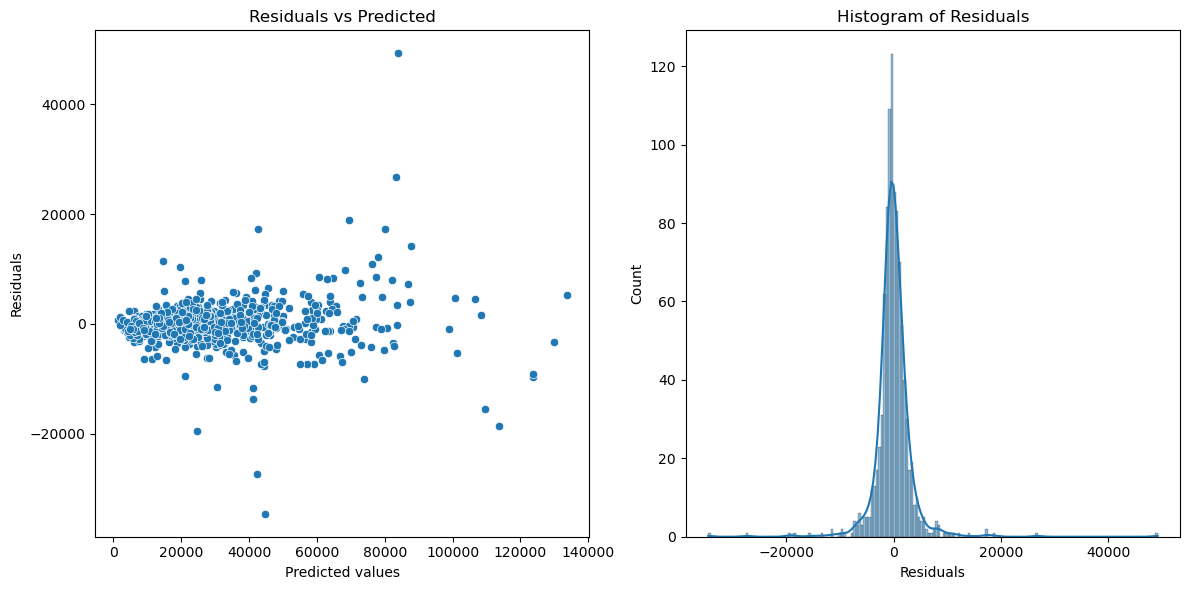

In [14]:
residuals = y_test - test_preds

# Plot residuals vs predicted
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=test_preds, y=residuals)
plt.title('Residuals vs Predicted')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

# Histogram of residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')

plt.tight_layout()
plt.show()

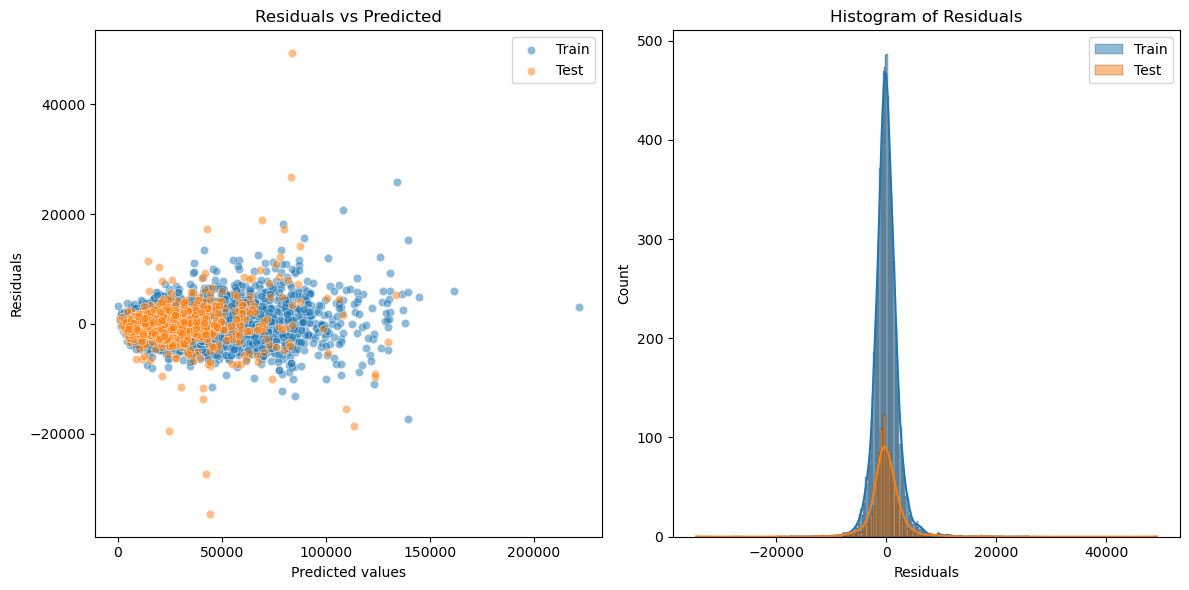

In [18]:
residuals_test = y_test - test_preds
residuals_train = y_train - train_preds

# Plot residuals vs predicted
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=train_preds, y=residuals_train,alpha=0.5,label='Train')
sns.scatterplot(x=test_preds, y=residuals_test,alpha=0.5,label='Test')
plt.legend()
plt.title('Residuals vs Predicted')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

# Histogram of residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals_train, kde=True, label='Train')
sns.histplot(residuals_test, kde=True, label='Test')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.legend()

plt.tight_layout()
plt.show()

## Feature importance

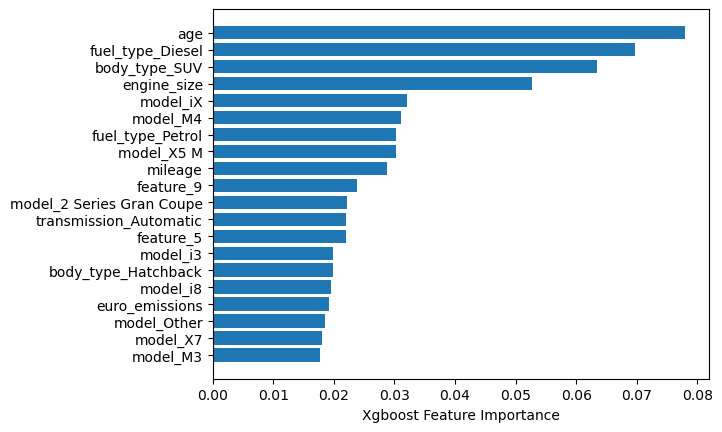

In [25]:
feature_importances = model.feature_importances_
len(feature_importances)

sorted_idx = feature_importances.argsort()
feature_names = np.array(list(preprocessor.transformers_[0][1].get_feature_names_out()) + list(preprocessor.transformers_[1][1].get_feature_names_out()))

plt.barh(feature_names[sorted_idx][len(feature_names)-20:], feature_importances[sorted_idx][len(feature_names)-20:])
plt.xlabel("Xgboost Feature Importance")
plt.show()

## Worst predictions
- made a start at this

In [22]:
df_res = pd.DataFrame({'Actual': y_test, 'Predicted': test_preds, 'Residual': residuals})
df_res['Absolute_Residual'] = df_res['Residual'].abs()
worst_predictions = df_res.nlargest(30, 'Absolute_Residual')  

worst_indices = worst_predictions.index
worst_features = X_test.loc[worst_indices]

worst_features

,model,body_type,fuel_type,engine_size,transmission,mileage,colour,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,euro_emissions,stopstart,motorsport,sport,doors,d_number,i_number,e_number,xdrive,se,steptronic,dct,touring,special_edition,competition,battery_capacity,age,plate_yearstart,plate_yearmiddle,plate_yearend,plate_time_of_year,mileage_per_year
801,iX,SUV,Electric,NaN,Automatic,10,Black,0,0,0,0,1,0,1,0,0,0,NaN,False,True,False,NaN,NaN,NaN,NaN,True,False,False,False,False,False,False,NaN,0,True,False,False,1.0,10.000000
500,6 Series,Coupe,Petrol,4.4,Automatic,43895,Silver,1,0,0,0,0,1,1,0,0,0,3.0,False,False,False,2.0,NaN,NaN,NaN,False,False,False,False,False,False,False,NaN,19,False,False,True,3.0,2194.750000
760,Other,Coupe,Petrol,5.0,Automatic,72501,Black,1,0,0,0,0,1,1,0,0,0,4.0,False,False,False,2.0,NaN,NaN,NaN,False,False,False,False,False,False,False,NaN,17,False,True,False,2.0,4027.833333
730,iX,SUV,Electric,NaN,Automatic,10,Grey,0,0,0,0,0,0,1,0,0,0,NaN,False,True,False,NaN,NaN,NaN,NaN,True,False,False,False,False,False,False,NaN,0,True,False,False,1.0,10.000000
358,5 Series,Saloon,Petrol,4.4,Automatic,75080,Blue,0,0,0,0,0,0,0,1,0,0,NaN,False,False,False,4.0,NaN,540.0,NaN,False,False,False,False,False,False,False,NaN,26,False,False,False,NaN,2780.740741
126,iX,SUV,Electric,NaN,Automatic,4363,White,0,0,0,1,1,0,1,0,0,0,NaN,False,True,False,NaN,NaN,NaN,NaN,True,False,False,False,False,True,False,NaN,1,False,False,True,3.0,2181.500000
175,M5,Saloon,Petrol,4.4,Automatic,10,Grey,0,1,0,0,0,0,1,0,0,0,6.0,True,False,False,4.0,NaN,NaN,NaN,True,False,True,False,False,False,True,NaN,0,True,False,False,1.0,10.000000
600,iX,SUV,Electric,NaN,Automatic,7107,Grey,1,0,0,1,1,0,1,0,0,0,NaN,False,True,False,NaN,NaN,NaN,NaN,True,False,False,False,False,True,False,NaN,1,False,False,True,3.0,3553.500000
95,M3,Saloon,Petrol,3.0,Automatic,17000,Blue,1,1,1,0,0,1,1,0,1,1,6.0,True,False,False,4.0,NaN,NaN,NaN,False,False,False,True,False,False,False,NaN,5,False,False,True,3.0,2833.333333
208,M5,Saloon,Petrol,4.4,Automatic,0,Grey,1,1,0,0,1,1,0,0,0,0,6.0,True,False,False,4.0,NaN,NaN,NaN,True,False,True,False,False,False,True,NaN,0,True,False,False,1.0,0.000000


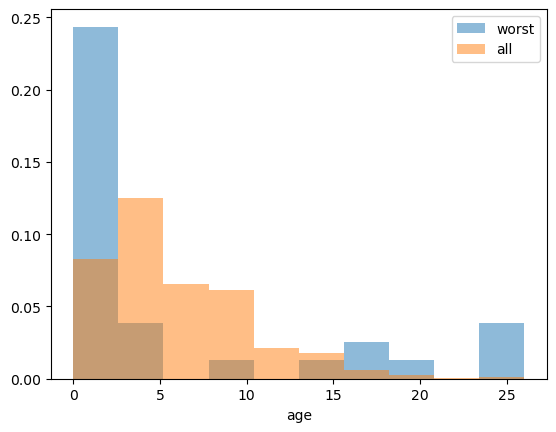

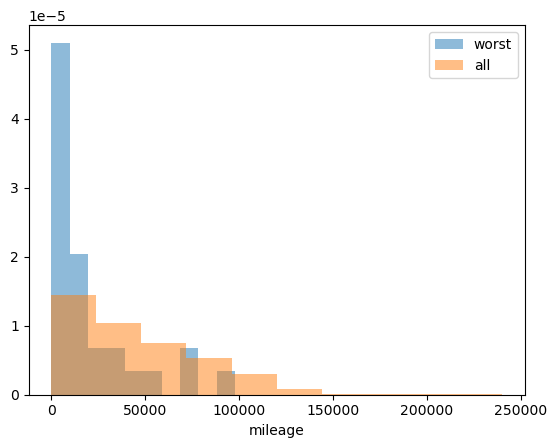

In [29]:
plt.hist(worst_features['age'],alpha=0.5,density=True,label='worst')
plt.hist(X_test['age'],alpha=0.5,density=True,label='all')
plt.xlabel('age')
plt.legend()
plt.show()
plt.hist(worst_features['mileage'],alpha=0.5,density=True,label='worst')
plt.hist(X_test['mileage'],alpha=0.5,density=True,label='all')
plt.xlabel('mileage')
plt.legend()
plt.show()

## Residuals vs price positions

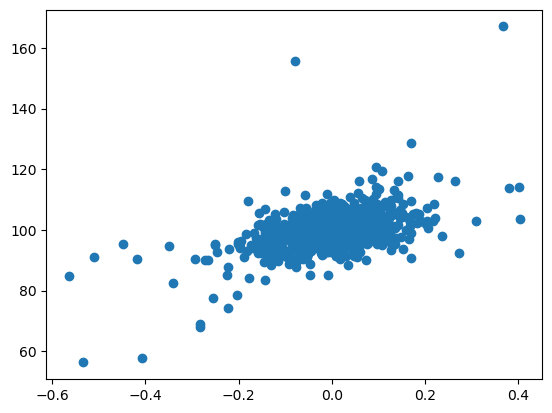

In [24]:
plt.scatter(df_res['Residual']/df_res['Predicted'], pd.read_csv('test_data_withpriceposition.csv')['price_position'])